In [4]:
# Blackrock US Pension Recommended Allocation as starting point: https://www.blackrock.com/institutions/en-us/insights/charts/capital-market-assumptions#strategic-asset-allocation
# Had to increase domestic equities to reach 30% threshold, took from non-US developed equities

In [10]:
import pandas as pd

# Read in data on benchmark returns and inflation, adjustments made for data gaps based on 5Y Monthly betas from Yahoo Finance
df = pd.read_csv('historical data.csv', index_col='Date', parse_dates=True)

# Calculate monthly returns for the 7 benchmarks
monthly_returns = df.pct_change().dropna()


# Your portfolio weights; adjustments to meet return hurdles and asset allocation constraints for fixed income, domestic equities
weights = {
    'SP500': 0.3,
    'MSCI_ACWI': 0.39 - 0.3,
    'MSCI_EM': 0.07,
    'US_10Y_Treas': .02,
    'US_10Y_TIPS': 0.049,
    'Bloomberg_Aggregate': 0.1,
    'Vanguard_SmallCap (Alts Proxy)': 1 - .3 - .09 - .07 - .02 - .049 - .1 - .1,
    'JPY Hedged Equity': .1
}

# Calculate the total sum of the weights
total_weights = sum(weights.values())
print(total_weights)

# Normalize each weight by dividing by the total sum
normalized_weights = {k: v / total_weights for k, v in weights.items()}

# Verify the sum of normalized weights
total_normalized = sum(weights.values())
print("Total of Normalized Weights:", total_normalized)
print("Normalized Weights:", normalized_weights)


# Drop any columns not in weights
filtered_monthly_returns = monthly_returns.drop(columns=[col for col in monthly_returns if col not in weights])

# Reorder the DataFrame columns to match the order of weights' keys
reordered_monthly_returns = filtered_monthly_returns[list(weights.keys())]

# Calculate weighted portfolio returns using the reordered DataFrame
portfolio_returns = reordered_monthly_returns.dot(pd.Series(weights))

# Assuming df['CPI'] represents the monthly change in CPI in percentage
inflation_rate = df['CPI']/100

# Calculate real returns
real_returns = (1 + reordered_monthly_returns).divide(1 + inflation_rate, axis=0) - 1
portfolio_real_returns = (1 + portfolio_returns).divide(1 + inflation_rate) - 1

# Calculate the 60-40 benchmark returns
sixty_forty_benchmark_returns = 0.6 * monthly_returns['SP500'] + 0.4 * monthly_returns['Bloomberg_Aggregate']
sixty_forty_real_returns = (1 + sixty_forty_benchmark_returns).divide(1 + inflation_rate) - 1

1.0
Total of Normalized Weights: 1.0
Normalized Weights: {'SP500': 0.3, 'MSCI_ACWI': 0.09000000000000002, 'MSCI_EM': 0.07, 'US_10Y_Treas': 0.02, 'US_10Y_TIPS': 0.049, 'Bloomberg_Aggregate': 0.1, 'Vanguard_SmallCap (Alts Proxy)': 0.271, 'JPY Hedged Equity': 0.1}


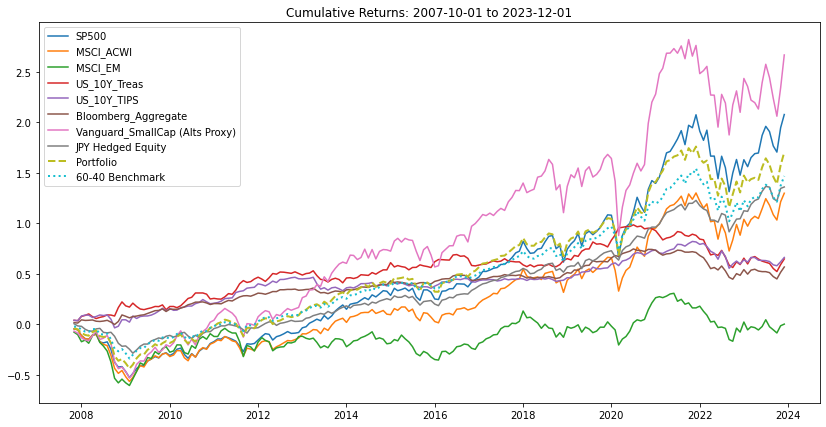

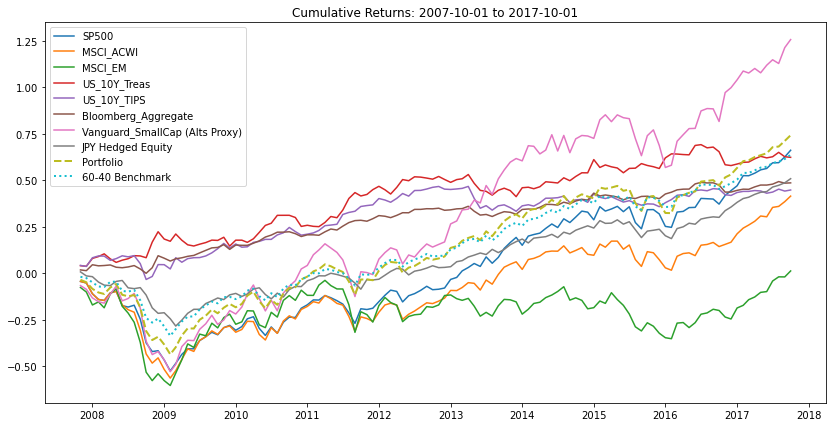

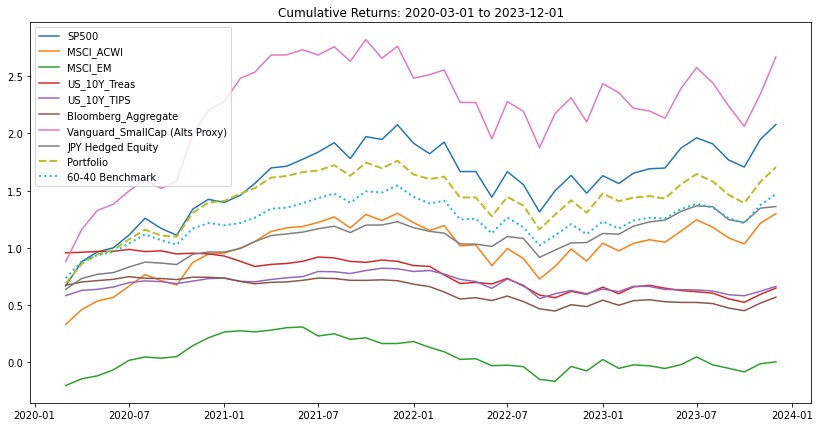

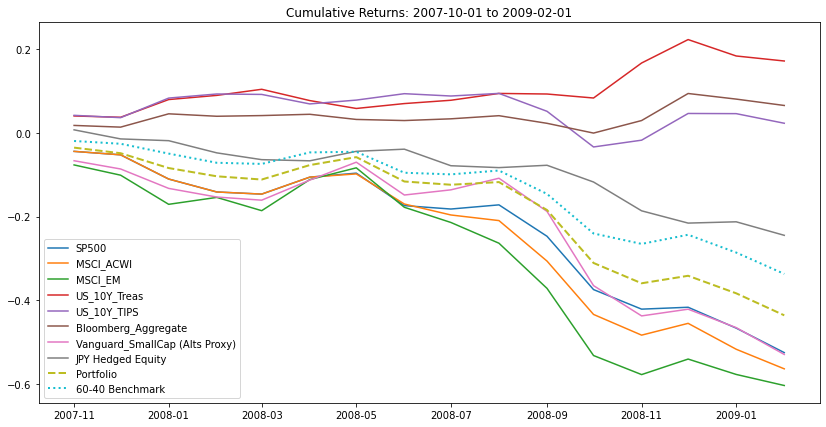

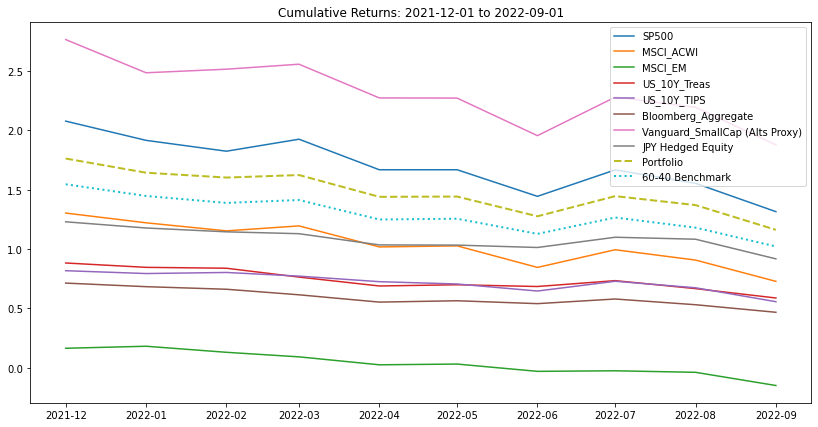

In [11]:
cumulative_returns = (1 + reordered_monthly_returns).cumprod() - 1
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1

# Calculate cumulative returns for the 60-40 benchmark
cumulative_sixty_forty_returns = (1 + sixty_forty_benchmark_returns).cumprod() - 1

import matplotlib.pyplot as plt

# Define periods
# Update the periods dictionary to include new peak-to-trough periods
periods = {
    '2007-10-01 to 2023-12-01': ('2007-10-01', '2023-12-01'),
    '2007-10-01 to 2017-10-01': ('2007-10-01', '2017-10-01'),
    '2020-03-01 to 2023-12-01': ('2020-03-01', '2023-12-01'),
    '2007-10-01 to 2009-02-01': ('2007-10-01', '2009-02-01'),  # New period 1
    '2021-12-01 to 2022-09-01': ('2021-12-01', '2022-09-01')   # New period 2
}

for name, (start, end) in periods.items():
    plt.figure(figsize=(14, 7))
    for ticker in weights.keys():
        plt.plot(cumulative_returns.loc[start:end, ticker], label=ticker)
    plt.plot(cumulative_portfolio_returns.loc[start:end], label='Portfolio', linewidth=2, linestyle='--')
    # Add the 60-40 benchmark to the plot
    plt.plot(cumulative_sixty_forty_returns.loc[start:end], label='60-40 Benchmark', linewidth=2, linestyle=':')
    plt.title(f'Cumulative Returns: {name}')
    plt.legend()
    plt.show()


In [12]:
# Function to calculate performance metrics for a given period
def calculate_performance_metrics(returns, real_returns, start_date, end_date):
    # Isolate the period
    period_returns = returns.loc[start_date:end_date]
    period_real_returns = real_returns.loc[start_date:end_date]

    # Calculate metrics
    avg_nominal_returns = period_returns.mean() * 12  # Annualize
    cumulative_nominal_returns = (1 + period_returns).prod() - 1
    avg_real_returns = period_real_returns.mean() * 12  # Annualize

    # Combine into a DataFrame
    metrics_df = pd.DataFrame({
        'Avg Nominal Return': avg_nominal_returns,
        'Cumulative Nominal Return': cumulative_nominal_returns,
        'Avg Real Return': avg_real_returns
    })

    return metrics_df

# Define periods
# Update the periods dictionary to include new peak-to-trough periods
periods = {
    '2007-10-01 to 2023-12-01': ('2007-10-01', '2023-12-01'),
    '2007-10-01 to 2017-10-01': ('2007-10-01', '2017-10-01'),
    '2020-03-01 to 2023-12-01': ('2020-03-01', '2023-12-01'),
    '2007-10-01 to 2009-02-01': ('2007-10-01', '2009-02-01'),  # New period 1
    '2021-12-01 to 2022-09-01': ('2021-12-01', '2022-09-01')   # New period 2
}

# Calculate and display metrics for each period
for period_name, (start, end) in periods.items():
    print(f"Metrics for {period_name}:")
    metrics_df = calculate_performance_metrics(reordered_monthly_returns, real_returns, start, end)
    portfolio_metrics = calculate_performance_metrics(portfolio_returns.to_frame("Portfolio"), portfolio_real_returns.to_frame("Portfolio"), start, end)
    # Calculate metrics for the 60-40 benchmark
    sixty_forty_metrics = calculate_performance_metrics(sixty_forty_benchmark_returns.to_frame("60-40 Benchmark"), sixty_forty_real_returns.to_frame("60-40 Benchmark"), start, end)
    # Combine all metrics into a single DataFrame
    combined_metrics_df = pd.concat([metrics_df, portfolio_metrics.loc['Portfolio'].to_frame().T, sixty_forty_metrics.loc['60-40 Benchmark'].to_frame().T], axis=0)
    print(combined_metrics_df)
    print("\n---\n")

Metrics for 2007-10-01 to 2023-12-01:
                                Avg Nominal Return  Cumulative Nominal Return  \
SP500                                     0.082976                   2.078541   
MSCI_ACWI                                 0.067010                   1.299546   
MSCI_EM                                   0.024143                   0.003544   
US_10Y_Treas                              0.033337                   0.648508   
US_10Y_TIPS                               0.033494                   0.663486   
Bloomberg_Aggregate                       0.029028                   0.568917   
Vanguard_SmallCap (Alts Proxy)            0.102231                   2.668436   
JPY Hedged Equity                         0.056530                   1.361311   
Portfolio                                 0.071182                   1.705757   
60-40 Benchmark                           0.061397                   1.469839   

                                Avg Real Return  
SP500               

In [13]:
# Function to calculate performance metrics for a given period
def calculate_performance_metrics(returns, real_returns, start_date, end_date):
    rfr = .033
    # Isolate the period
    period_returns = returns.loc[start_date:end_date]
    period_real_returns = real_returns.loc[start_date:end_date]

    # Calculate metrics
    avg_nominal_returns = period_returns.mean() * 12  # Annualize
    cumulative_nominal_returns = (1 + period_returns).prod() - 1
    avg_real_returns = period_real_returns.mean() * 12  # Annualize
    volatility = period_returns.std() * (12 ** 0.5)  # Annualize standard deviation
    sharpe_ratios = (avg_nominal_returns - rfr) / volatility


    # Combine into a DataFrame
    metrics_df = pd.DataFrame({
        'Avg Nominal Return': avg_nominal_returns,
        'Cumulative Nominal Return': cumulative_nominal_returns,
        'Avg Real Return': avg_real_returns,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratios
    }, index=[0])  # Added an index here

    return metrics_df

# Define periods
# Update the periods dictionary to include new peak-to-trough periods
periods = {
    '2007-10-01 to 2023-12-01': ('2007-10-01', '2023-12-01'),
    '2007-10-01 to 2017-10-01': ('2007-10-01', '2017-10-01'),
    '2020-03-01 to 2023-12-01': ('2020-03-01', '2023-12-01'),
    '2007-10-01 to 2009-02-01': ('2007-10-01', '2009-02-01'),  # New period 1
    '2021-12-01 to 2022-09-01': ('2021-12-01', '2022-09-01')   # New period 2
}

# Adjust the portion of your code that combines metrics DataFrames
for period_name, (start, end) in periods.items():
    print(f"Metrics for {period_name}:")
    
    metrics_df = calculate_performance_metrics(reordered_monthly_returns, real_returns, start, end)
    # Calculate metrics for the custom portfolio
    custom_portfolio_metrics = calculate_performance_metrics(portfolio_returns, portfolio_real_returns, start, end)
    custom_portfolio_metrics.index = ['Custom Portfolio']  # Assign a meaningful index
    
    # Calculate metrics for the 60-40 benchmark
    sixty_forty_metrics = calculate_performance_metrics(sixty_forty_benchmark_returns, sixty_forty_real_returns, start, end)
    sixty_forty_metrics.index = ['60-40 Benchmark']  # Assign a meaningful index
    
    # Combine all metrics into a single DataFrame for display
    combined_metrics_df = pd.concat([metrics_df, custom_portfolio_metrics, sixty_forty_metrics], axis=0)
    
    print(combined_metrics_df)
    print("\n---\n")


Metrics for 2007-10-01 to 2023-12-01:
                  Avg Nominal Return  Cumulative Nominal Return  \
0                                NaN                        NaN   
Custom Portfolio            0.071182                   1.705757   
60-40 Benchmark             0.061397                   1.469839   

                  Avg Real Return  Volatility  Sharpe Ratio  
0                             NaN         NaN           NaN  
Custom Portfolio         0.047302    0.137050      0.278600  
60-40 Benchmark          0.037631    0.103218      0.275118  

---

Metrics for 2007-10-01 to 2017-10-01:
                  Avg Nominal Return  Cumulative Nominal Return  \
0                                NaN                        NaN   
Custom Portfolio            0.064109                   0.743053   
60-40 Benchmark             0.053720                   0.637216   

                  Avg Real Return  Volatility  Sharpe Ratio  
0                             NaN         NaN           NaN  
Custom P

In [14]:
#Still track better than S&P 500, more volatility but more long-run return than 60-40 portfolio
#To add zero beta strategies in alts to course correct

In [15]:
import pandas as pd

# Assumptions provided by Blackrock - all net of fees
assumptions = {
    'Domestic Equities': {'Annual Return': 4.8, 'Volatility': 17.4},
    'International Developed Equities': {'Annual Return': 8.6, 'Volatility': 17.0},
    'Emerging Market Equities': {'Annual Return': 8.4, 'Volatility': 20.8},
    'US Cash': {'Annual Return': 4.0, 'Volatility': 0},
    'US_10Y_TIPS': {'Annual Return': 4.2, 'Volatility': 5.3},
    'Corporate Agg Fixed Income': {'Annual Return': 4.0, 'Volatility': 5.1},
    'Alts - PE/VC': {'Annual Return': 9.9, 'Volatility': 32.3},
    'Alts - Global Hedge Funds': {'Annual Return': 7.6, 'Volatility': 6.2}
}

# Portfolio weights
portfolios = {
    'TIPC Portfolio': {
    'Domestic Equities': 0.3,
    'International Developed Equities': 0.09,
     'Emerging Market Equities': 0.07,
    'US Cash': 0.02,
    'US_10Y_TIPS': 0.04,
    'Corporate Agg Fixed Income': 0.1,
    'Alts - PE/VC': 0.271,
        'Alts - Global Hedge Funds': 0.1
        
    },
    '60-40 Benchmark': {
        'Domestic Equities': 0.6,
        'Corporate Agg Fixed Income': 0.4
    }
}

# Risk-free rate for Sharpe ratio calculation
risk_free_rate = 4.3

# Loop through each portfolio to calculate metrics
for portfolio_name, weights in portfolios.items():
    # Calculate expected return
    expected_return = sum(assumptions[asset]['Annual Return'] * weight for asset, weight in weights.items())
    
    # Assuming perfect correlation for simplification
    portfolio_volatility = sum(weights[asset] * assumptions[asset]['Volatility'] for asset in weights)  # Simplified
    
    # Calculate Sharpe ratio
    sharpe_ratio = (expected_return - risk_free_rate) / portfolio_volatility
    
    # Print results
    print(f"{portfolio_name}:")
    print(f"  Expected Return: {expected_return}%")
    print(f"  Volatility: {portfolio_volatility}%")
    print(f"  Sharpe Ratio: {sharpe_ratio}\n")


TIPC Portfolio:
  Expected Return: 6.8929%
  Volatility: 18.3013%
  Sharpe Ratio: 0.14167846000010928

60-40 Benchmark:
  Expected Return: 4.48%
  Volatility: 12.48%
  Sharpe Ratio: 0.01442307692307697



In [16]:
#Idiosyncratic Shock Analysis

In [17]:
# Forward-looking assumptions and custom portfolio weights
assumptions = {
    'Domestic Equities': {'Annual Return': 4.8, 'Volatility': 17.4},
    'International Developed Equities': {'Annual Return': 8.6, 'Volatility': 17.0},
    'Emerging Market Equities': {'Annual Return': 8.4, 'Volatility': 20.8},
    'US Cash': {'Annual Return': 4.0, 'Volatility': 0},
    'US_10Y_TIPS': {'Annual Return': 4.2, 'Volatility': 5.3},
    'Corporate Agg Fixed Income': {'Annual Return': 4.0, 'Volatility': 5.1},
    'Alts - PE/VC': {'Annual Return': 9.9, 'Volatility': 32.3},
    'Alts - Global Hedge Funds': {'Annual Return': 7.6, 'Volatility': 6.2}
}

custom_portfolio_weights = {
    'Domestic Equities': 0.3,
    'International Developed Equities': 0.09,
     'Emerging Market Equities': 0.07,
    'US Cash': 0.02,
    'US_10Y_TIPS': 0.04,
    'Corporate Agg Fixed Income': 0.1,
    'Alts - PE/VC': 0.271,
        'Alts - Global Hedge Funds': 0.1
    }

# Loop through each asset in the custom portfolio
for shocked_asset in custom_portfolio_weights.keys():
    # Calculate portfolio return with one asset shocked
    portfolio_return_with_shock = 0
    for asset, weight in custom_portfolio_weights.items():
        if asset == shocked_asset:
            # Apply a 1% downside shock to the shocked asset's return
            shocked_return = 0
        else:
            # Use the expected return for other assets
            shocked_return = assumptions[asset]['Annual Return']
        
        portfolio_return_with_shock += weight * shocked_return
    
    print(f"Portfolio return with a 100% shock to {shocked_asset}: {portfolio_return_with_shock}%")

Portfolio return with a 100% shock to Domestic Equities: 5.4529%
Portfolio return with a 100% shock to International Developed Equities: 6.1189%
Portfolio return with a 100% shock to Emerging Market Equities: 6.3049%
Portfolio return with a 100% shock to US Cash: 6.8129%
Portfolio return with a 100% shock to US_10Y_TIPS: 6.7249%
Portfolio return with a 100% shock to Corporate Agg Fixed Income: 6.492900000000001%
Portfolio return with a 100% shock to Alts - PE/VC: 4.21%
Portfolio return with a 100% shock to Alts - Global Hedge Funds: 6.1329%
